In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ruptures.detection import Pelt
import ruptures as rpt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Data Exploration

In [2]:
# Load data
data = pd.read_csv('..\data\BrentOilPrices.csv', parse_dates=['Date'], dayfirst=True)

In [3]:
# Display first few rows
data.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [ ]:
data.shape

In [4]:
# Check for missing values
data.isnull().sum()

Date     0
Price    0
dtype: int64

In [5]:
# check the data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9011 non-null   datetime64[ns]
 1   Price   9011 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 140.9 KB


In [6]:
# Check for negative prices
negative_prices = data[data['Price'] < 0]
print("Negative Prices:\n", negative_prices)

Negative Prices:
 Empty DataFrame
Columns: [Date, Price]
Index: []


In [7]:
# Check for zero prices
zero_prices = data[data['Price'] == 0]
print("Zero Prices:\n", zero_prices)

Zero Prices:
 Empty DataFrame
Columns: [Date, Price]
Index: []


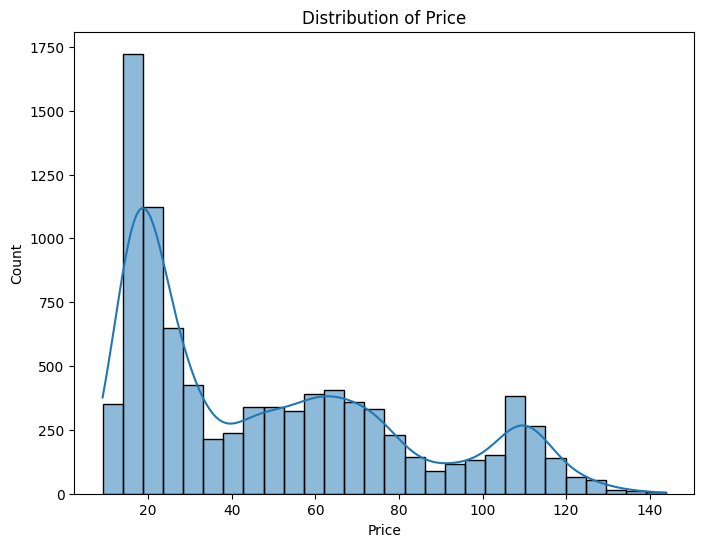

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Price'], kde=True)  # Histogram with KDE
plt.title('Distribution of Price')
plt.show()

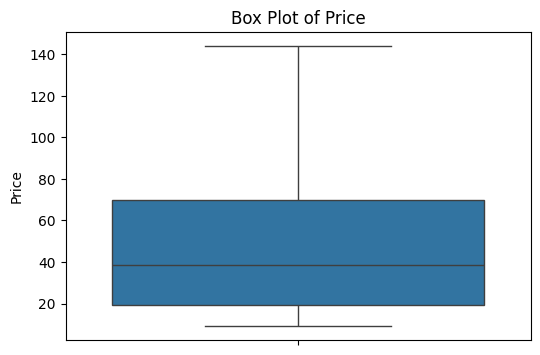

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=data['Price'])
plt.title('Box Plot of Price')
plt.show()

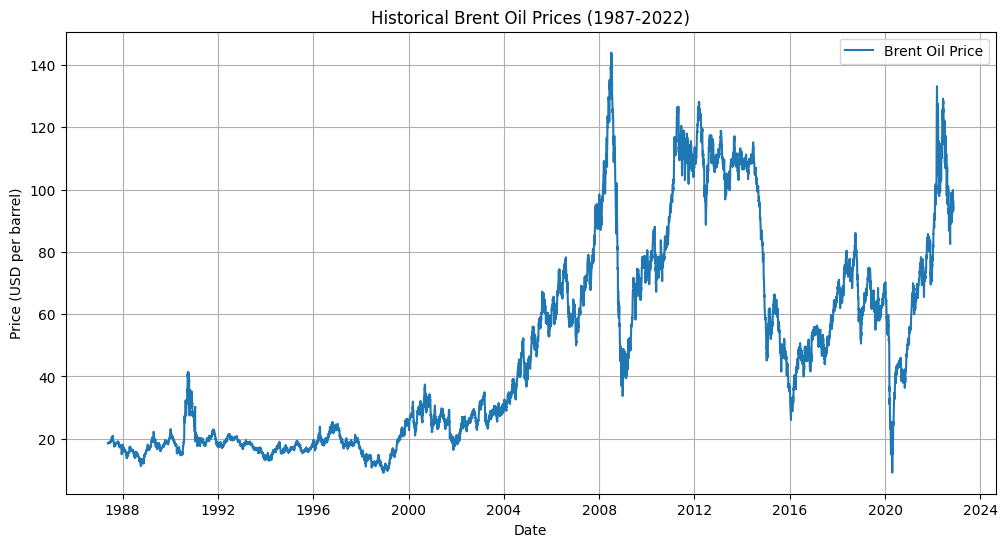

In [10]:
# Plot historical prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'], label='Brent Oil Price')
plt.title('Historical Brent Oil Prices (1987-2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.grid()
plt.show()

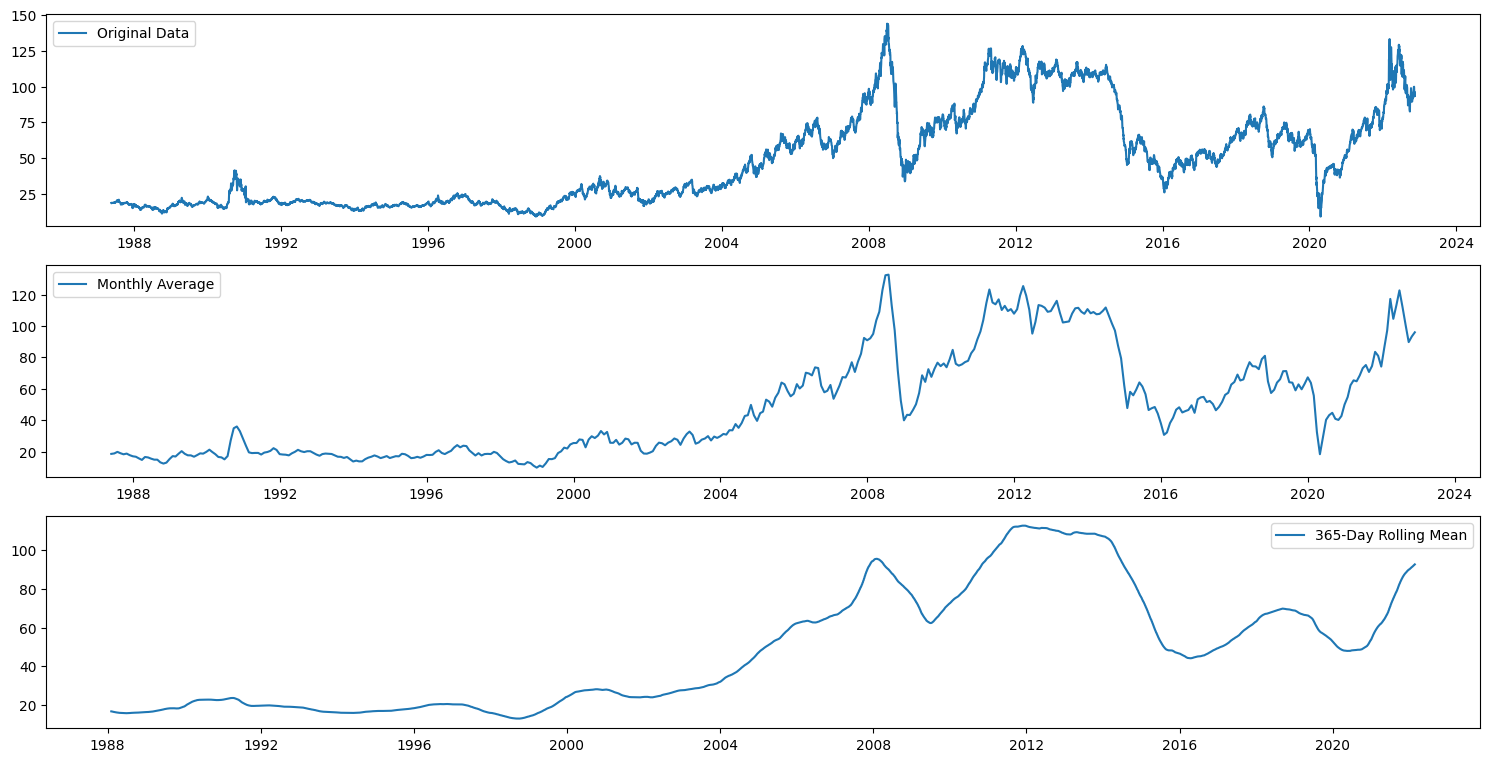

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resampling to monthly
monthly_data = data.resample('M', on='Date')['Price'].mean()

# 365-day rolling average
data['yearly_rolling_mean'] = data['Price'].rolling(window=365, center=True).mean() # center=True is important

# Time Series Decomposition
decomposition = seasonal_decompose(data['Price'], model='additive', period=365) # Period is crucial here!

# Plotting
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(data['Date'], data['Price'], label='Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(monthly_data.index, monthly_data.values, label='Monthly Average')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data['Date'], data['yearly_rolling_mean'], label='365-Day Rolling Mean')
plt.legend()

plt.tight_layout()
plt.show()

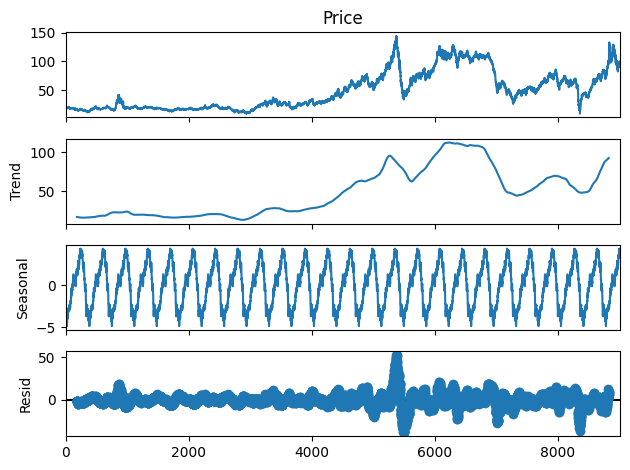

In [ ]:
# Plots trend, seasonality, and residual separately
decomposition.plot()  
plt.show()

In [15]:
data = data.set_index('Date')

In [16]:
# Set the frequency to daily
data = data.resample('D').ffill()

## Stationarity Check

In [17]:
from statsmodels.tsa.stattools import adfuller
# Perform ADF test
result = adfuller(data['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the result
if result[1] <= 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -1.9488216105940648
p-value: 0.3094536250793654
Critical Values:
   1%: -3.4308561991797255
   5%: -2.8617637154959716
   10%: -2.566889078817277
The data is non-stationary (fail to reject the null hypothesis).


In [18]:
# Apply differencing
data['Price_diff'] = data['Price'].diff().dropna()

In [19]:
# drop naa
data = data.dropna()

# Change Point Analysis

In [20]:
# Convert prices to numpy array
prices = data['Price'].values

In [21]:
# Detect change points
algo = rpt.Pelt(model="rbf").fit(prices)
change_points = algo.predict(pen=10)  # Adjust penalty parameter as needed

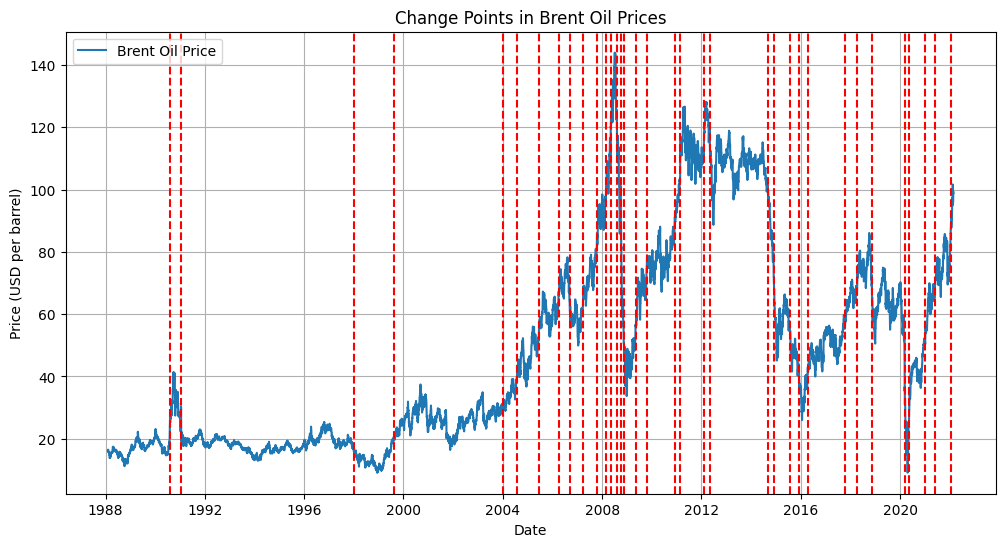

In [24]:
# Plot change points
plt.figure(figsize=(12, 6))
plt.plot(data.index, prices, label='Brent Oil Price')
for cp in change_points[:-1]:
    plt.axvline(x=data.index[cp], color='r', linestyle='--')
plt.title('Change Points in Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.grid()
plt.show()

# Time Series Modeling

In [25]:
# Fit ARIMA model
model_arima = ARIMA(data['Price'], order=(5, 1, 0))  # Adjust order as needed
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                12438
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -16864.538
Date:                Fri, 21 Feb 2025   AIC                          33741.077
Time:                        18:21:11   BIC                          33785.647
Sample:                    02-05-1988   HQIC                         33756.001
                         - 02-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0026      0.006      0.472      0.637      -0.008       0.014
ar.L2         -0.0087      0.007     -1.338      0.181      -0.021       0.004
ar.L3          0.0081      0.006      1.456      0.1

In [26]:
# Fit GARCH model
model_garch = arch_model(data['Price'], vol='Garch', p=1, q=1)  # Adjust p and q as needed
results_garch = model_garch.fit()
print(results_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 262034417248.53006
Iteration:      2,   Func. Count:     12,   Neg. LLF: 25483999.414254077
Iteration:      3,   Func. Count:     19,   Neg. LLF: 440851.7790399748
Iteration:      4,   Func. Count:     26,   Neg. LLF: 74218.50740600718
Iteration:      5,   Func. Count:     33,   Neg. LLF: 55249.60612792579
Iteration:      6,   Func. Count:     40,   Neg. LLF: 57361.866363037065
Iteration:      7,   Func. Count:     46,   Neg. LLF: 53300.23509466696
Iteration:      8,   Func. Count:     52,   Neg. LLF: 51001.54968040078
Iteration:      9,   Func. Count:     57,   Neg. LLF: 77372.21297674757
Iteration:     10,   Func. Count:     66,   Neg. LLF: 54522.01091012561
Iteration:     11,   Func. Count:     72,   Neg. LLF: 50829.190918334425
Iteration:     12,   Func. Count:     78,   Neg. LLF: 49084.140706228616
Iteration:     13,   Func. Count:     83,   Neg. LLF: 112634.4310418862
Iteration:     14,   Func. Count:     91,   Neg. LLF: 53009

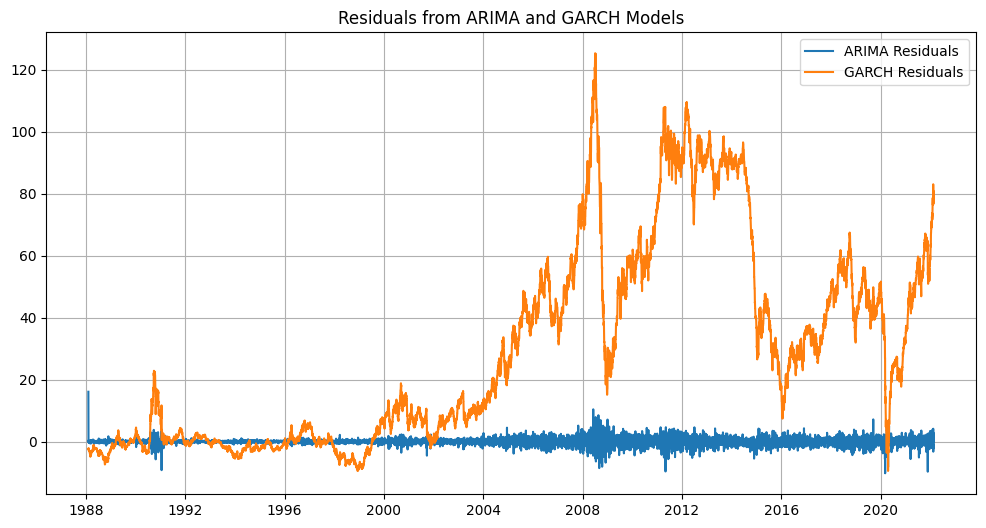

In [27]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(results_arima.resid, label='ARIMA Residuals')
plt.plot(results_garch.resid, label='GARCH Residuals')
plt.title('Residuals from ARIMA and GARCH Models')
plt.legend()
plt.grid()
plt.show()